<a href="https://colab.research.google.com/github/philqc/Dynamic-Capacity-Network/blob/master/DCN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dynamic Capacity Network  (DCN) implentation using pytorch. This specific code is for MNIST
but it is pretty easy to change the data set as all functions related to the DCN are generalized
to take any data set, patch size, # of patches, etc. 

---


Author:  Philippe Beardsell

---



Based on Tensorflow implementation from Sangheum Hwang found at https://github.com/beopst/dcn.tf

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from torch.utils.data.dataset import Dataset  # For custom datasets
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import random
from os.path import exists
import os
import pickle
import csv
import time
import math
import imageio
from matplotlib.patches import Rectangle
from torch.autograd import Variable

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Using cuda !
      9         2         4         5         2         4  


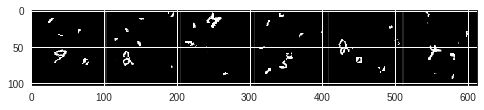

In [4]:

image_size = 100
  
batch_size = 128
batch_size_eval = 512
  

added_path = 'drive/My Drive/mnist-cluttered-master/'
set_classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
  
num_classes = 10

assert len(set_classes) == num_classes

# If a GPU is available, use it
if torch.cuda.is_available():
    device = torch.device("cuda")
    use_cuda = True
    print('Using cuda !')
else:
    device = torch.device("cpu")
    use_cuda = False
    print('GPU not available !')


class CustomDataset(Dataset):
    def __init__(self, data_path, label_path=None, transform=None):
        """
        Args:
            label_path (string): path to .txt file
            data_path (string): path to the folder where images are
            transform (callable, optional): Optional transform to be applied
               on a sample.
        """

        # Read the npy file
        self.data = np.load(data_path)
          
        # Calculate len
        self.data_len = len(self.data)
        
        # Read the txt file
        if label_path:
            self.label_arr = np.load(label_path, encoding='latin1')
        else:
            # Test set ! no labels available
            self.label_arr = np.zeros(self.data_len)

        self.transform = transform

    def __getitem__(self, index):

        # Get image label as integer .txt file
        label = int(self.label_arr[index])
        
        # data has 1-10 notation..
        label -= 1

        # Open image
        sample = (self.data[index]).reshape(1, image_size, image_size)
        
        sample = torch.from_numpy(sample)

        if self.transform:
            sample = self.transform(sample)

        return sample, label

    def __len__(self):
        return self.data_len


# Augment data with small rotation

transform_train = transforms.Compose([
    # need to transform to pili image to  apply transforms
    transforms.ToPILImage(),
    transforms.RandomRotation((-30, 30)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
  
    
transform_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


train_data = CustomDataset(added_path + 'train_images.npy',
                           added_path + 'train_labels.npy',
                           transform_train)

n_train_images = len(train_data)

valid_data = CustomDataset(added_path + 'valid_images.npy',
                           added_path + 'valid_labels.npy', 
                           transform_test)

n_valid_images = len(valid_data)

test_data = CustomDataset(added_path + 'test_images.npy',
                          added_path + 'test_labels.npy',
                          transform_test)

n_test_images = len(test_data)

 
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    pin_memory=use_cuda
)

valid_loader = DataLoader(
    valid_data,
    batch_size=batch_size_eval,
    pin_memory=use_cuda,
)

test_loader = DataLoader(
    test_data,
    batch_size=batch_size_eval,
    pin_memory=use_cuda,
)


def print_some_image(loader, n_images):
    # visualize and understand the data
    # get some random training images
    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    # show images
    imshow(utils.make_grid(images[:n_images]))
    # print labels
    print(' '.join('  %5s  ' % set_classes[labels[j]] for j in range(n_images)))
    

# visualize and understand the data
def imshow(img):
    npimg = img.numpy()
    plt.imshow(img[0, :, :], cmap='Greys_r')
    
    
def print_one_image(img, label):
    plt.figure()
    plt.imshow(img[0, :, :], cmap='Greys_r')
    plt.title(label)
    plt.show()
        

def compute_RF_numerical(net, img_np):
    """"
    Taken FROM : https://github.com/rogertrullo/Receptive-Field-in-Pytorch/blob/master/compute_RF.py
    compute receptive field of convnet, to be able to find salient patches
    @param net: Pytorch network
    @param img_np: numpy array to use as input to the networks, it must be full of ones and with the correct
    shape.
    """
    grads_img = {}

    def save_grad(name):
        def hook(grad):
            grads_img[name] = grad

        return hook
      
     
    def weights_init(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            m.weight.data.fill_(1)
            m.bias.data.fill_(0)
    
    net.apply(weights_init)
    image = Variable(torch.from_numpy(img_np).float(), requires_grad=True).to(device)
    out_cnn = net(image)
    out_shape = out_cnn.size()
    ndims = len(out_cnn.size())

    grad = torch.zeros(out_cnn.size()).to(device)
    l_tmp = []

    for i in range(ndims):
        if i == 0 or i == 1:  # batch or channel
            l_tmp.append(0)
        else:
            l_tmp.append(int(out_shape[i] / 2))

    print(tuple(l_tmp))
    grad[tuple(l_tmp)] = 1
    
    image.register_hook(save_grad('y'))
    out_cnn.backward(gradient=grad)
    
    grad_np = grads_img['y'][0, 0].data.cpu().numpy()
    idx_nonzeros = np.where(grad_np != 0)
    RF = [np.max(idx)-np.min(idx) + 1 for idx in idx_nonzeros]

    return RF, out_cnn.size()
  
  

print_some_image(train_loader, 6)


Coarse Model Here

In [0]:
######## Info about coarse layers to extract patches
# Define the coarse layers for both the extract patches methods and
# for the actually definition of the ConvLayer
# [0] = kernel size, [1] = stride, [2] = padding
coarse_layers = [[7, 2, 0], [3, 2, 0]]
currentLayer = [image_size, 1, 1, 0.5]


class CoarseLayers(nn.Module):
    """ Coarse layers: 2 convolutional layers, with 7 x 7 and
        3 x 3 filter sizes, 12 and 24 filters, respectively, and a
        2 x 2 stride. Each feature in the coarse feature maps
        covers a patch of size 11x11 pixels, which we extend
        by 3 pixels in each side to give the fine layers more
        context. The size of the coarse feature map is 23 x 23. (DCN Paper)
    """

    def __init__(self, test_receptive_field):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, n_filters, kernel_size=coarse_layers[0][0],
                               stride=coarse_layers[0][1], padding=coarse_layers[0][2])
        self.bn1 = nn.BatchNorm2d(n_filters)
        self.conv2 = nn.Conv2d(n_filters, 2 * n_filters, kernel_size=coarse_layers[1][0],
                               stride=coarse_layers[1][1], padding=coarse_layers[1][2])
        self.bn2 = nn.BatchNorm2d(2 * n_filters)

        self.test_receptive_field = test_receptive_field

    def forward(self, x):
        # need to turn off batchnorm
        # before using the compute receptive field function
        # x is [batch_size, channels, height, width] = [bs, 1, 100, 100]
        if self.test_receptive_field:
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
        else:
            x = F.relu(self.bn1(self.conv1(x)))
            x = F.relu(self.bn2(self.conv2(x)))

        return x


#########################################################
def outFromIn(conv, layerIn):
    """ Taken from 
    https://medium.com/mlreview/a-guide-to-receptive-field
    -arithmetic-for-convolutional-neural-networks-e0f514068807
    
    Computes receptive field and relevant variables
    to compute the coordinates of the salient patches 
    for the coarse model
    """
    n_in = layerIn[0]
    j_in = layerIn[1]
    r_in = layerIn[2]
    start_in = layerIn[3]
    k = conv[0]
    s = conv[1]
    p = conv[2]

    n_out = math.floor((n_in - k + 2 * p) / s) + 1
    actualP = (n_out - 1) * s - n_in + k
    pR = math.ceil(actualP / 2)
    pL = math.floor(actualP / 2)

    j_out = j_in * s
    r_out = r_in + (k - 1) * j_in
    start_out = start_in + ((k - 1) / 2 - pL) * j_in
    return n_out, j_out, r_out, start_out


layer_infos = []
for i in range(len(coarse_layers)):
    currentLayer = outFromIn(coarse_layers[i], currentLayer)
    layer_infos.append(currentLayer)
    
####################################
# Variables of the receptive field of our coarse model
# So that we can compute efficiently the top left corner of
# the patch of the salient features
####################################

# jump of pixels in put for each index   
jump_get_top = layer_infos[-1][1]
receptive_field = layer_infos[-1][2]
length_half = (receptive_field / 2.0)
# If added padding add it here, here padding = 3
length_half += (3 / 2.0)
start_get_top = layer_infos[-1][3] - length_half

def get_top_left_patches(indexes, map_h):
    """ 
    Taken from 
    https://medium.com/mlreview/a-guide-to-receptive-field
    -arithmetic-for-convolutional-neural-networks-e0f514068807
    (with small modifications)
     returns top left coordinates of the rectangle of the patch
     @params: map_h = feature_map height (size of output of coarse model)
              indexes = indexes in the feature map of salient patch
    """
    # indexes [i, j] are now flattened
    # consider x axis from left to right, and y axis from top to bottowm
    # for example if index = map_h - 1, then idx_x = map_h - 1, and idx_y = 0
    indexes = indexes.long().to(device)
    idx_y = indexes / map_h
    idx_x = torch.fmod(indexes, map_h)
           
    # n = layer_infos[-1][0]
    #assert (x < n for x in idx_x)
    #assert (y < n for y in idx_y)
    
    # Coordinates are (0, 0) at top left of image
    # so moving right increase X, and moving down increase Y
    # we take top left coordinates of rectangle
    x_top_left = (start_get_top + idx_x * jump_get_top).view(-1, 1)
    y_top_left = (start_get_top + idx_y * jump_get_top).view(-1, 1)
    #print('x_top_left = ', x_top_left, ' y_top_left = ', y_top_left)

    coords = torch.cat((x_top_left, y_top_left), 1)  # .to(device)

    return coords, idx_x, idx_y

################################################




In [63]:
#####################################################
# n_patches fed into fine layers
n_patches = 8
n_filters = 12
n_filters_input_top = 24
# Turn hint_loss on/off
add_hint_loss = True
only_coarse_model = False
only_fine_model = False
size_patch = [14, 14]
# both can't be true !
assert not(only_fine_model and only_coarse_model)


class FineLayers(nn.Module):
    """ Fine layers: 5 convolutional layers, each with 3 x 3
        filter sizes, 1x1 strides, and 24 filters. We apply 2x2
        pooling with 2 x 2 stride after the second and fourth
        layers. We also use 1 x 1 zero padding in all layers
        except for the first and last layers. This architecture
        was chosen so that it maps a 14 x 14 patch into one
        spatial location. (DCN paper)
    """

    def __init__(self, test_receptive_field):
        super().__init__()
        # input 100x100 images

        self.conv1 = nn.Conv2d(1, n_filters_input_top, kernel_size=3, padding=0, stride=1)
        self.bn1 = nn.BatchNorm2d(n_filters_input_top)
        self.conv2 = nn.Conv2d(n_filters_input_top,  n_filters_input_top, kernel_size=3, padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(n_filters_input_top)
        # max pool here
        self.conv3 = nn.Conv2d(n_filters_input_top,  n_filters_input_top, kernel_size=3, padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(n_filters_input_top)
        self.conv4 = nn.Conv2d(n_filters_input_top, n_filters_input_top, kernel_size=3, padding=1, stride=1)
        self.bn4 = nn.BatchNorm2d(n_filters_input_top)
        # max pool here

        self.conv5 = nn.Conv2d(n_filters_input_top, n_filters_input_top, kernel_size=3, padding=0, stride=1)
        self.bn5 = nn.BatchNorm2d(n_filters_input_top)

        self.test_receptive_field = test_receptive_field

    def forward(self, x):
        # x is [batch_size, channels, height, width] = [bs, 1, 100, 100]

        if self.test_receptive_field:
            # average pooling instead of max pooling for computing receptive field
            # https://github.com/rogertrullo/Receptive-Field-in-Pytorch
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = F.avg_pool2d(x, 2, stride=2)
            x = F.relu(self.conv3(x))
            x = F.relu(self.conv4(x))
            x = F.avg_pool2d(x, 2, stride=2)
            x = F.relu(self.conv5(x))

        else:
            x = F.relu(self.bn1(self.conv1(x)))
            x = F.relu(self.bn2(self.conv2(x)))
            x = F.max_pool2d(x, 2, stride=2)
            x = F.relu(self.bn3(self.conv3(x)))
            x = F.relu(self.bn4(self.conv4(x)))
            x = F.max_pool2d(x, 2, stride=2)
            x = F.relu(self.bn5(self.conv5(x)))

        return x

class TopLayers(nn.Module):
    """ Top layers: one convolutional layer with 4 x 4 filter
        size, 2x2 stride and 96 filters, followed by global max
        pooling. The result is fed into a n_class-output softmax
        layer. (DCN paper)
    """

    def __init__(self):
        super().__init__()
        # get input of n_filters channels from coarse layers
        self.conv1 = nn.Conv2d(n_filters_input_top, 96, kernel_size=4, stride=2)
        self.bn1 = nn.BatchNorm2d(96)
        
        self.fc1 = nn.Linear(96, num_classes)


    def forward(self, x):
      
        # x is [batch_size, channels, height, width] = [bs, 1, image_size, image_size]
        x = F.relu(self.bn1(self.conv1(x)))
        # global max pooling
        x = F.max_pool2d(x, kernel_size=x.size()[2:])
        
        # x should now be a n_filters * 4 channels of 1x1
        x = x.view(x.size(0), -1)  # flatten       
        x = self.fc1(x)
              
        return x

      
def find_salient_input_regions(grads, batch_size):
    """ Identify top k saliency scores.
         @param : grads: gradient of the entropy with respect to features
    """
    
    # Find the saliency matrix M
    M = torch.sqrt((torch.sum(-grads, dim=1)).pow(2))

    # Flatten M to be a Batch_Size times (dim_x times dim_y feature_coarse) matrix
    # we then choose the n_patches entries with the highest entropy
    # for every individual picture
    M_reshape = M.view(batch_size, -1)

    values, indices = torch.topk(M_reshape, n_patches)

    assert indices.shape == (batch_size, n_patches)

    return indices


class EntropyLoss(nn.Module):
    """ Entropy loss
    https://discuss.pytorch.org/t/calculating-the-entropy-loss/14510"""

    def __init__(self):
        super(EntropyLoss, self).__init__()

    def forward(self, x):
        b = F.softmax(x, dim=1) * F.log_softmax(x, dim=1)
        b = -1.0 * b.sum()
        return b


def print_feature_map(images, arr_top_left_rectangle):
    """ Show the patches that we will feed as inputs to the fine layers """

    ax = plt.gca()
    
    colors = cm.rainbow(np.linspace(0, 1, len(arr_top_left_rectangle)))

    for i, s in enumerate(arr_top_left_rectangle):
        # Taking the top left corner directly yields 
        # the rectangle in the right spot
        ax.add_patch(Rectangle((s[0], s[1]), size_patch[0], size_patch[1],
                               color=colors[i], fill=False, linewidth=0.6))
    
    ax.imshow(images[0, :, :], cmap='Greys_r')
      
    plt.show()
 
      
def extract_patches(inputs, batch_size, top_left_coord):
    """
        Before entering here, we are already looping
        on the n_patches, so we now loop on all batches

    @param inputs: 
    @param batch_size:
    @param top_left_coord: top left coordinates of the patches
    """
    
    #print('inputs.shape', inputs.shape)
    #unpacked = torch.unbind(inputs)
    #print('unpacked.shape', unpacked.shape)

    patches = []

    for i in range(batch_size):

        # slicing X axis from bottom left rectangle
        # moving right increase X so this is OK
        sliced = inputs[i].narrow(2, top_left_coord[i, 0], size_patch[0])

        # because we slice second, now tensor is 3d, so we slice at 1 !
        # to get_center_points, Y coordinates is maximum at right
        # bottom corner, so we have to slice by going up !
        sliced = sliced.narrow(1, top_left_coord[i, 1], size_patch[1])
        
        # we should now have a shape of the size of the region
        # that the fine model takes as input
        # assert sliced.shape == (1, size_patch[0], size_patch[1])

        patches.append(sliced)
        
    patches = torch.stack(patches)

    # Should be Batch_size x 1 x (size_patch[0] x size_patch[1])
    # assert patches.shape == (batch_size, 1, size_patch[0], size_patch[1])

    return patches


def extract_one_feature(inputs, indexes, map_h, batch_size):
       
    top_left_coord, idx_i, idx_j = get_fast_top_left_patches(indexes, map_h)
    
    patches = extract_patches(inputs, batch_size, top_left_coord)
    
    src_idxs = torch.cat((idx_i.view(-1, 1), idx_j.view(-1, 1)), 1).to(device)

    return src_idxs, patches, top_left_coord


def extract_features(inputs, model_fine, batch_size,
                     k_indexes, map_h, is_plot_feature_map):
    """ Extract top k fine features
    """
    
    # Randomly select 1 image to visualize patches
    random_index = random.randrange(len(inputs))
    arr_top_left_coord_rand = []

    k_src_idxs = []
    k_patches = []

    for i in range(n_patches):    
      
        src_idxs, patches, top_left_coord = extract_one_feature(inputs, k_indexes[:, i], map_h, batch_size)
        
        arr_top_left_coord_rand.append(top_left_coord[random_index, :])

        k_src_idxs.append(src_idxs)
        k_patches.append(patches)

    if is_plot_feature_map:
        # print some image of the batch with the feature map
        assert len(arr_top_left_coord_rand) == n_patches
        print_feature_map(inputs[random_index, :], arr_top_left_coord_rand)

    concat_patches = torch.cat(k_patches, 0).to(device)
    
    assert concat_patches.shape == (batch_size * n_patches, 1, size_patch[0], size_patch[1])

    # Now compute the fine layers on the set of patches
    concat_k_features = model_fine(concat_patches)

    k_features = torch.split(concat_k_features, n_patches, 0)

    return k_features, k_src_idxs


def replace_features(coarse_features, fine_features, replace_idxs):
    """ Replace fine features with the corresponding coarse features
    """

    batch_size, map_channel, map_height, map_width = coarse_features.size()

    # TODO: simplify indexing
    def _convert_to_1d_idxs(src_idxs):
        """ Convert 2D idxs to 1D idxs
            within 1D tensor whose shape is (b*h*w*c)
        """
        batch_idx_len = map_channel * map_width * map_height
        batch_idx_base = (torch.Tensor([i * batch_idx_len for i in range(batch_size)]).long()).to(device)

        batch_1d = map_channel * map_width * src_idxs[:, 0] + map_channel * src_idxs[:, 1]
        batch_1d = torch.add(batch_1d, batch_idx_base)

        flat_idxs = [batch_1d + i for i in range(map_channel)]
        flat_idxs = (torch.stack(flat_idxs)).t()
        flat_idxs = flat_idxs.contiguous().view(-1)
        return flat_idxs

    # flatten coarse features
    flat_coarse_features = coarse_features.view(-1)

    # flatten fine features
    flat_fine_features = [i.view(-1) for i in fine_features]
    flat_fine_features = torch.cat(flat_fine_features, 0)

    flat_fine_idxs = [_convert_to_1d_idxs(i) for i in replace_idxs]
    flat_fine_idxs = torch.cat(flat_fine_idxs, 0)

    # extract coarse features to be replaced
    # this is required for hint-based training
    flat_coarse_replaced = torch.gather(flat_coarse_features, 0, flat_fine_idxs)

    # Make sure we are replacing the same size !
    if flat_coarse_replaced.size() != flat_fine_features.size():
        print('Assertion error : flat_coarse_replaced.size()', flat_coarse_replaced.size(),
              ' !=  flat_fine_features.size()', flat_fine_features.size())
        assert flat_coarse_replaced.size() == flat_fine_features.size()


    # We now merge our two features, start by the coarse model
    # and we will insert the features of the model with their indexes
    merged = flat_coarse_features
    # Switch all the coarse features for the fine features
    merged[flat_fine_idxs] = flat_fine_features

    merged = merged.view(coarse_features.size())

    # This should be Batch Size x n_filters x
    # (size of coarse feature map = (dim_x_feature_coarse x dim_y_feature_coarse))
    if merged.size() != (batch_size, n_filters_input_top, dim_x_feature_coarse, dim_y_feature_coarse):
        print('Assert error : merged.size()', merged.size(), '!= batch_size', batch_size,
              ' x n_filters_input_top', n_filters_input_top, 'x dim_x_feature_coarse', dim_x_feature_coarse,
              ' x dim_y_feature_coarse', dim_y_feature_coarse)
        assert merged.size() == (batch_size, n_filters_input_top, dim_x_feature_coarse, dim_y_feature_coarse)

    return merged, flat_coarse_replaced, flat_fine_features



def inference(inputs, model_coarse, model_fine, model_top, is_training, is_plot_feature_map):
    
    # Special cases
    if only_coarse_model:
        # Only using coarse model (for benchmark performance)
        coarse_features = model_coarse(inputs)
        output_coarse = model_top(coarse_features)
        return output_coarse, torch.Tensor([0]).to(device)
    elif only_fine_model:
        # Only using fine model (for benchmark performance)
        fine_features = model_fine(inputs)
        output_fine = model_top(fine_features)
        return output_fine, torch.Tensor([0]).to(device)
    ######################################################
    grads = {}

    def save_grad(name):
        def hook(grad):
            grads[name] = grad

        return hook

    with torch.enable_grad():
        entropy_loss_fn = EntropyLoss()
        coarse_features = model_coarse(inputs)

        output_coarse = model_top(coarse_features)
        # Apply softmax on output + compute entropy
        entropy = entropy_loss_fn(output_coarse)

        # Save gradient of the entropy with respect to
        # the coarse vectors c_{i, j}, this used for inference
        # while training but ALSO while validating and testing !
        coarse_features.register_hook(save_grad('y'))
        # First time we use backward, we should set retain_graph=True
        # to make a backward pass that will not delete intermediary results
        entropy.backward(retain_graph=True)
        optimizer.zero_grad()
  
 
    batch_size, map_channel, map_height, map_width = coarse_features.size()

    # Find the top_k_indices where the entropy is maximized
    top_k_indices = find_salient_input_regions(grads['y'], batch_size)
    
    # Compute the fine layers over the n_batches, and also return their indices
    # so we can replace the features of the coarse model by the features of the fine model
    fine_features, fine_indexes = extract_features(inputs, model_fine, batch_size,
                                                   top_k_indices, map_height, is_plot_feature_map)

    # merge two feature maps
    merged, flat_coarse_replaced, flat_fine_features = replace_features(coarse_features, fine_features, fine_indexes)

    if add_hint_loss:
        # Compute the Raw Hint Loss to minimize the squared distance
        # between the coarse and fine representations
        raw_hint_loss = torch.sum((flat_coarse_replaced - flat_fine_features).pow(2), dim=0)

        # scale hint loss per example in batch
        # still does not match range of 5-25 shown in figure 2 in paper???
        hint_loss = raw_hint_loss / (batch_size * n_patches)
    else:
        hint_loss = torch.Tensor([0]).to(device)

    # finally, apply our model on merged features
    output_merged = model_top(merged)
    
    return output_merged, hint_loss


def train(model_coarse, model_fine, model_top, optimizer, 
          loss_fn_fine_top, epoch):
    
    # set to train mode
    model_coarse.train()
    model_fine.train()
    model_top.train()

    time_now = time.clock()

    for batch_idx, (inputs, target) in enumerate(train_loader):

        inputs, target = inputs.to(device), target.to(device)
        # necessary to change to float !
        inputs = inputs.float()
        # target should be changed to long
        target = target.long()

        # reset grads for all models
        optimizer.zero_grad()

        is_plot_feature_map = (batch_idx == 0)

        output_merged, hint_loss = inference(inputs, model_coarse, model_fine, model_top,
                                             is_training=True, is_plot_feature_map=is_plot_feature_map)
              
        # Top + Fine layers only consider the cross entropy loss
        loss_fine_and_top = loss_fn_fine_top(output_merged, target)
        
        # Hint loss
        if add_hint_loss:    
            # Combine Cross Entropy loss + hint_loss for coarse model
            loss_coarse_model = loss_fine_and_top + hint_loss  
            
            for param in model_fine.parameters():
                param.requires_grad = False
            for param in model_top.parameters():
                param.requires_grad = False
        
            # we should set retain_graph = True
            # to make a backward pass that will not delete intermediary results
            loss_coarse_model.backward(retain_graph=True)

            for param in model_fine.parameters():
                param.requires_grad = True
            for param in model_top.parameters():
                param.requires_grad = True
            for param in model_coarse.parameters():
                param.requires_grad = False    

            loss_fine_and_top.backward()

            for param in model_coarse.parameters():
                param.requires_grad = True                
        else:
          # no hint loss, much simpler..
          loss_fine_and_top.backward()
            

        optimizer.step()
        #################

        if batch_idx % 10 == 0:
            print('\rTrain Epoch: {} [{}/{} ({:.0f}%)] Time per epoch: {:.2f}s'   
                  '  Total_Loss: {:.4f} (CrossEntropy: {:.2f} Hint: {:.2f})'
                  ''.format(epoch, batch_idx * len(inputs), n_train_images, 100. * batch_idx / len(train_loader),
                            n_train_images / (10 * batch_size) * (time.clock() - time_now),
                            loss_fine_and_top.item() + hint_loss.item(), loss_fine_and_top.item(), hint_loss.item()),
                  end='')
            time_now = time.clock()


def test(model_coarse, model_fine, model_top, test_loss_fn_fine_top, loader):
    # First, important to set models to eval mode
    model_coarse.eval()
    model_fine.eval()
    model_top.eval()

    avg_test_loss, avg_hint_loss = 0, 0
    correct = 0
    test_size = 0

    with torch.no_grad():
        for inputs, target in loader:
            inputs, target = inputs.to(device), target.to(device)
            
            inputs = inputs.float()
            target = target.long()

            output_merged, hint_loss = inference(inputs, model_coarse, model_fine, model_top,
                                                 is_training=False, is_plot_feature_map=False)

            test_size += len(inputs)
            # sum up batch loss
            avg_test_loss += test_loss_fn_fine_top(output_merged, target).item()
            avg_hint_loss += len(inputs) * hint_loss.item()
            pred = output_merged.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    avg_test_loss /= test_size
    avg_hint_loss /= test_size
    accuracy = correct / test_size
    print('\nTest set: Avg_Total_Loss: {:.4f} (CrossEntropy: {:.2f} Hint: {:.2f})' 
          '  Accuracy: {}/{} ({:.0f}%)\n'
          .format(avg_test_loss + avg_hint_loss, avg_test_loss, avg_hint_loss, 
                  correct, test_size, 100. * accuracy))

    return avg_test_loss, accuracy



RF_coarse, out_size_coarse = compute_RF_numerical(CoarseLayers(True).to(device), np.ones((1, 1, image_size, image_size)))
dim_x_feature_coarse, dim_y_feature_coarse = out_size_coarse[2], out_size_coarse[3]
print('receptive field coarse model =', RF_coarse, 'out.size() =', out_size_coarse)
print('--------------------------------------------------------')
RF_fine, out_size_fine = compute_RF_numerical(FineLayers(True).to(device), np.ones((1, 1, size_patch[0],
                                                                                    size_patch[1])))
print('receptive field fine model =', RF_fine, 'out.size() =', out_size_fine)
# For Fine model ---> input is patch_size and should output a SINGLE number
print('--------------------------------------------------------')






(0, 0, 11, 11)
receptive field coarse model = [11, 11] out.size() = torch.Size([1, 24, 23, 23])
--------------------------------------------------------
(0, 0, 0, 0)
receptive field fine model = [14, 14] out.size() = torch.Size([1, 24, 1, 1])
--------------------------------------------------------


Run the model

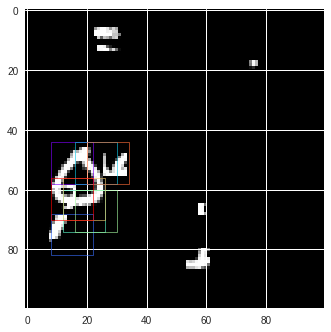

Train Epoch: 0 [8960/20000 (45%)] Time per epoch: 32.10s  Total_Loss: 33.6536 (CrossEntropy: 2.05 Hint: 31.60)

KeyboardInterrupt: ignored

In [62]:
n_epochs = 30

model_coarse = CoarseLayers(False).to(device)

model_fine = FineLayers(False).to(device)
model_top_layers = TopLayers().to(device)

# This is the loss *PLUS* the hint loss
loss_fn_fine_top = nn.CrossEntropyLoss()
test_loss_fn_fine_top = nn.CrossEntropyLoss(reduction='sum')

learning_rate = 0.001
# Adam optimizer
if only_coarse_model:
    optimizer = optim.Adam(list(model_coarse.parameters())
                           + list(model_top_layers.parameters()), lr=learning_rate)
elif only_fine_model:
    optimizer = optim.Adam(list(model_fine.parameters())
                           + list(model_top_layers.parameters()), lr=learning_rate)
else:
    optimizer = optim.Adam(list(model_coarse.parameters())
                           + list(model_fine.parameters())
                           + list(model_top_layers.parameters()), lr=learning_rate)

    
# Save learning curves
savedir = added_path + 'results'
if not os.path.exists(savedir):
    os.makedirs(savedir)

results = {'name': 'basic', 'lr': learning_rate, 'loss': [], 'accuracy': []}
savefile = os.path.join(savedir, results['name'] + str(results['lr']) + '.pkl')

for ep in range(n_epochs):
    train(model_coarse, model_fine, model_top_layers, optimizer, loss_fn_fine_top, ep)
    loss, acc = test(model_coarse, model_fine, model_top_layers, test_loss_fn_fine_top, valid_loader)

    # save results every epoch
    results['loss'].append(loss)
    results['accuracy'].append(acc)
    with open(savefile, 'wb') as fout:
        pickle.dump(results, fout)


# at the end, do test set

print('Checking accuracy on test set')            
test(model_coarse, model_fine, model_top_layers, test_loss_fn_fine_top, test_loader)
